In [7]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import sparse
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.spatial import cKDTree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar

warnings.filterwarnings("ignore", category=sparse.SparseEfficiencyWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Reading data
print("Reading data...")
data = pd.read_csv('Data/Final/Dataset.csv')
london_shp = gpd.read_file('Data/Revised/Geography/MSOA/London_2021.shp')

# Merge the data
data['Code_2021'] = data['Code_2021'].astype(str)
london_shp['msoa21cd'] = london_shp['msoa21cd'].astype(str)
gdf = london_shp.merge(data, left_on='msoa21cd', right_on='Code_2021', how='inner')

Reading data...


In [3]:
# Sample data
gdf = gdf.sample(n=min(5000, len(gdf)), random_state=42)

print("GDF shape:", gdf.shape)

GDF shape: (5000, 20)


Creating spatial weights...
Preparing data...
Fitting model...
Spatial autoregressive parameter (rho): 0.1
Individual-level variance (sigma2_e): 1.0
Group-level variance (sigma2_u): 0.1
Fixed effects coefficients (beta):
    Variable   Coefficient
0  Intercept  3.768222e-17
1        PC1  8.999651e-02
2        PC2 -1.075143e-01


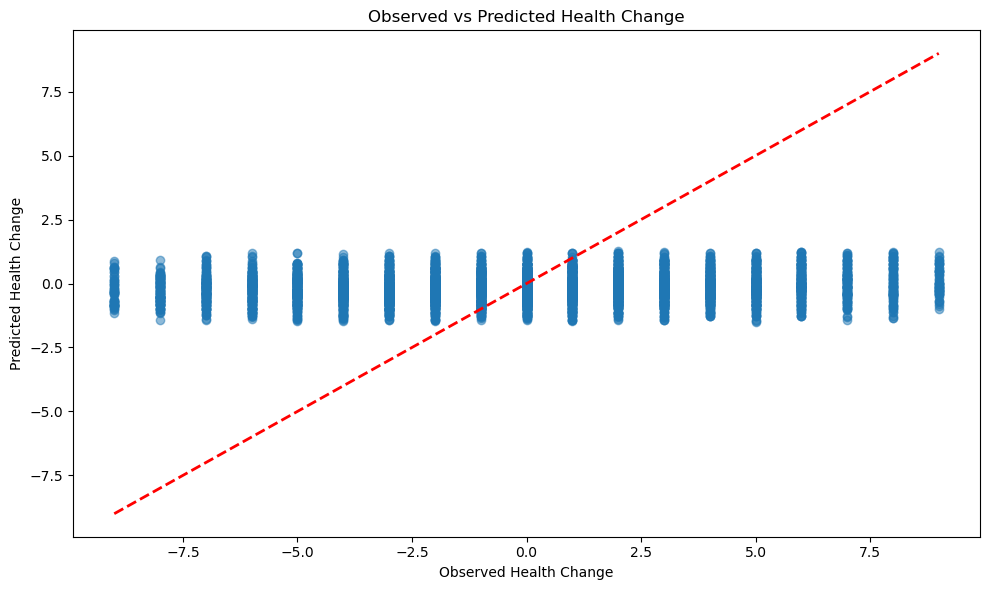

In [4]:
# Create spatial weights matrix
def create_spatial_weights(gdf, k=5):
    print("Creating spatial weights...")
    coords = np.column_stack((gdf.geometry.centroid.x, gdf.geometry.centroid.y))
    tree = cKDTree(coords)
    distances, indices = tree.query(coords, k=k+1)
    distances, indices = distances[:, 1:], indices[:, 1:]
    weights = 1 / (distances + 1e-10)
    weights = weights / np.sum(weights, axis=1, keepdims=True)
    rows = np.repeat(np.arange(len(gdf)), k)
    cols = indices.flatten()
    return sparse.csr_matrix((weights.flatten(), (rows, cols)), shape=(len(gdf), len(gdf)))

# Create spatial weights matrix
W = create_spatial_weights(gdf)

# Prepare data
print("Preparing data...")
X = gdf[['IMD_Change', 'Count']].values
y = gdf['Health_Change'].values

# Standardize X and y
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Use PCA for dimensionality reduction to reduce multicollinearity
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Add intercept term
X_pca = np.column_stack((np.ones(X_pca.shape[0]), X_pca))

# Create design matrix Z (assuming each MSOA is a group)
Z = sparse.csr_matrix((np.ones(len(gdf)), 
                       (range(len(gdf)), gdf.groupby('msoa21cd').ngroup())))

# Define SAR-MLM log-likelihood function
def sar_mlm_loglik(params, y, X, Z, W):
    n = len(y)
    k = X.shape[1]
    rho, sigma2_e, sigma2_u = params[:3]
    beta = params[3:]
    
    I_rhoW = sparse.eye(n) - rho * W
    Sigma_u = sigma2_u * (Z @ Z.T)
    Sigma = sigma2_e * sparse.eye(n) + Sigma_u
    
    # Use Cholesky decomposition to compute determinant and inverse for stability
    try:
        L = sparse.linalg.cholesky(Sigma.tocsc())
        logdet_Sigma = 2 * np.sum(np.log(L.diagonal()))
        Sigma_inv = sparse.linalg.inv(L) @ sparse.linalg.inv(L.T)
    except:
        return np.inf  # Return a large value if Cholesky decomposition fails
    
    detI_rhoW = np.sum(np.log(np.abs(sparse.linalg.eigsh(I_rhoW, k=1, which='LM', return_eigenvectors=False))))
    
    res = I_rhoW @ y - X @ beta
    loglik = -0.5 * n * np.log(2 * np.pi) + detI_rhoW - 0.5 * logdet_Sigma - 0.5 * res.T @ Sigma_inv @ res
    
    return -loglik

# Define SAR-MLM estimator
class SARMLM:
    def fit(self, y, X, Z, W):
        n, k = X.shape
        
        # Initial parameter estimates
        initial_params = np.zeros(k + 3)
        initial_params[0] = 0.1  # rho
        initial_params[1] = 1.0  # sigma2_e (variance should be close to 1 after standardization)
        initial_params[2] = 0.1  # sigma2_u
        initial_params[3:] = np.linalg.lstsq(X, y, rcond=None)[0]  # beta
        
        # Maximize the log-likelihood function
        print("Fitting model...")
        result = minimize(sar_mlm_loglik, initial_params, args=(y, X, Z, W),
                          method='Nelder-Mead', options={'maxiter': 2000})
        
        self.params = result.x
        self.rho = self.params[0]
        self.sigma2_e = self.params[1]
        self.sigma2_u = self.params[2]
        self.beta = self.params[3:]
        
        return self

# Fit the model
model = SARMLM().fit(y_scaled, X_pca, Z, W)

# Print results
print("Spatial autoregressive parameter (rho):", model.rho)
print("Individual-level variance (sigma2_e):", model.sigma2_e)
print("Group-level variance (sigma2_u):", model.sigma2_u)
print("Fixed effects coefficients (beta):")
print(pd.DataFrame({'Variable': ['Intercept'] + [f'PC{i+1}' for i in range(X_pca.shape[1]-1)], 
                    'Coefficient': model.beta}))

# Calculate model predictions
y_pred_scaled = (sparse.eye(len(y_scaled)) - model.rho * W) @ (X_pca @ model.beta)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Observed Health Change')
plt.ylabel('Predicted Health Change')
plt.title('Observed vs Predicted Health Change')
plt.tight_layout()

output_path = "Data/model.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

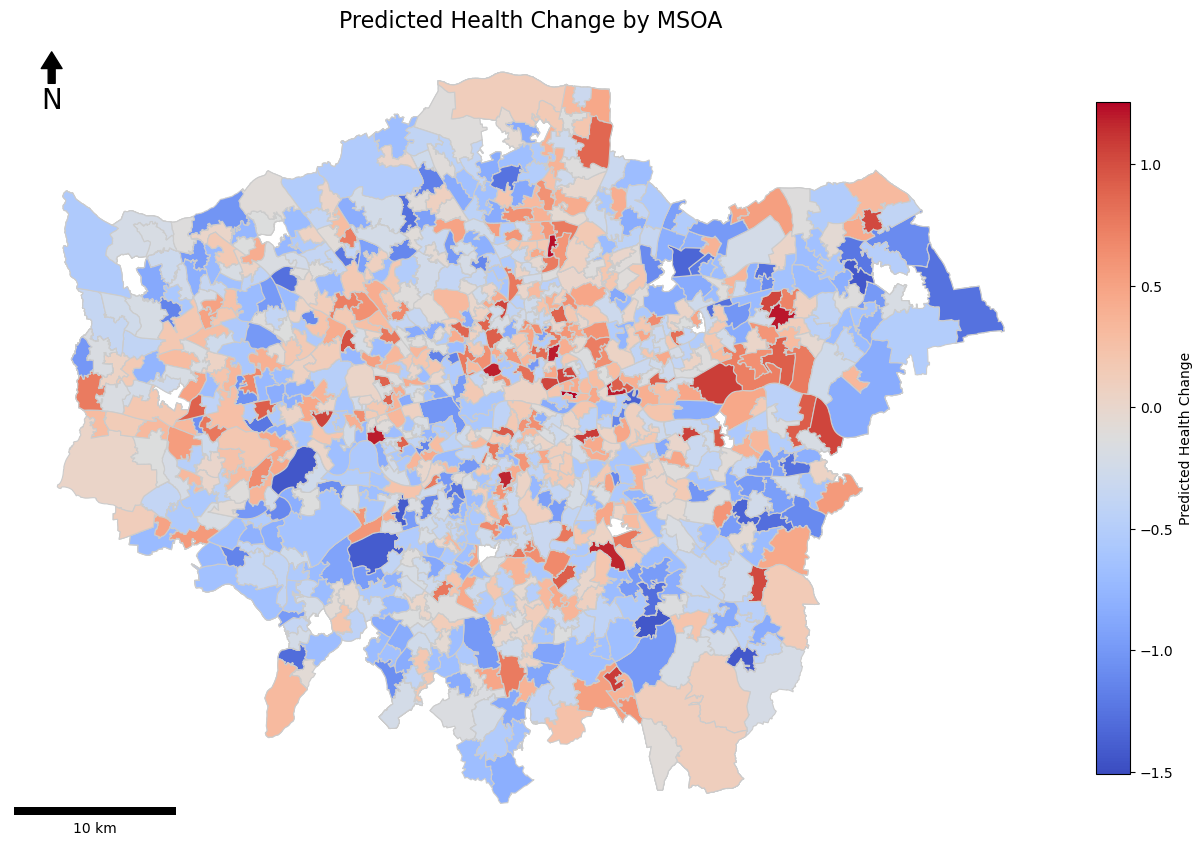

In [12]:
# Visualize predicted health change on the map
gdf['predicted_health_change'] = y_pred

# Set font and colormap
plt.rcParams['font.family'] = 'DejaVu Sans'
cmap = 'coolwarm'

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Plot the predicted health change
gdf.plot(
    column='predicted_health_change',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8'
)

# Add title and turn off axis
ax.set_title('Predicted Health Change by MSOA', fontsize=16)
ax.axis('off')

# Add North arrow
x, y, arrow_length = 0.04, 0.98, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords='axes fraction', zorder=5)

# Add scale bar with units in meters and set the background to transparent
scalebar = ScaleBar(dx=1, units="m", location='lower left', scale_loc='bottom', length_fraction=0.2, box_alpha=0)
ax.add_artist(scalebar)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=gdf['predicted_health_change'].min(), vmax=gdf['predicted_health_change'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Predicted Health Change')

# Adjust layout
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Save the figure as an image
output_path = "Data/Predicted Health Change by MSOA.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()